In [1]:
import numpy as np
from scipy.linalg import svd
import ness
import rxnet
import conformers
import hsp90
import plot_kinetics as pltk

In [2]:
import cPickle as pickle

In [3]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams.update( {'font.size': 16})

## ATP and cochaperone driven Hsp90 conformational cycle

In [4]:
SCALEFORWARD = 1
SCALEREVERSE = 1<<1
SCALEBOTH = SCALEFORWARD | SCALEREVERSE
def enumerate_rate_values( rates, rx, scalewhich, npts=20, smin=-2, smax=2):
    if isinstance( rx, list):
        rxs = rx
        ks = np.zeros( (npts, len(rxs), 2))
    else:
        rxs = [ rx ]
        ks = None

    for i, r in enumerate( rxs):
        krx = rates[r]
        s = np.logspace( smin, smax, npts)
        if (scalewhich & SCALEFORWARD):
            kf = krx[0]*s
        else:
            kf = krx[0]*np.ones( len(s))
        if (scalewhich & SCALEREVERSE):
            kr = krx[1]*s
        else:
            kr = krx[1]*np.ones( len(s))
        if ks is not None:
            ks[:, i, :] = np.array( [kf, kr]).T
    if ks is None:
        krx = np.array( [kf, kr]).T
    else:
        krx = ks
    return s, krx

def analyze_hsp90_noneq_vs_rates( rx, scalewhich, npts=20, smin=-2, smax=2, ATP=20, H=1.3, M=0.32, Q=1.3, AHA1=0,
                                  rates=None):
    if rates is None:
        rates = hsp90.BASE_RATES
    s, krx = enumerate_rate_values( rates, rx, scalewhich, npts, smin, smax)
    concs = { 'ATP': ATP, 'ADP': 1., 'Pi': 1., 'M': M, 'H': H, 'Q': Q, 'A': AHA1}
    cmols, mols, noneq = hsp90.ness_vs_krx( rates, concs, rx, krx)
    molid = dict([(m, i) for i, m in enumerate(mols)])
    pstates = hsp90.state_distribution( cmols, molid)
    return dict( values=s, active=cmols[:,molid['M_a']], noneq=noneq, pstates=pstates)

In [5]:
def analyze_hsp90_noneq_vs_concs( components, npts=20, cmin=0, cmax=15, ATP=20, H=1.3, M=0.32, Q=0, 
                                  spacing='linear', rates=None):
    if rates is None:
        rates = hsp90.BASE_RATES
    concs = { 'ATP': ATP, 'ADP': 1., 'Pi': 1., 'M': M, 'H': H, 'Q': Q}
    if 'A' in components:
        concs.update( {'A': 1.})
    if 'linear'==spacing: s = np.linspace( cmin, cmax, npts)
    else: s = np.logspace( np.log(cmin)/np.log(10), np.log(cmax)/np.log(10), npts)
    cmols, mols, noneq = hsp90.ness_vs_concs( rates, concs, components, s)
    molid = dict([(m, i) for i, m in enumerate(mols)])
    return dict( values=s, active=cmols[:,molid['M_a']], noneq=noneq)

In [6]:
def analyze_ATP_hydrolysis_vs_rates( rx, scalewhich, npts=20, smin=-2, smax=2, ATP=20, H=1.3, M=0.32, Q=1.3,
                                     rates=None):
    if rates is None:
        rates = hsp90.BASE_RATES
    concs = { 'ATP': ATP, 'ADP': 1., 'Pi': 1., 'M': 0, 'H': H, 'Q': 0}
    s, krx = enumerate_rate_values( rates, rx, scalewhich, npts, smin, smax)
    dATP0 = hsp90.dATP_vs_krx( rates, concs, rx, krx)
    concs.update( **dict(M=M, Q=Q))
    dATP = hsp90.dATP_vs_krx( rates, concs, rx, krx)
    # hydrolysis rate per Hsp90
    dATP0 /= H
    dATP /= H
    return dict( values=s, dATPdt=dATP, dATPdt0=dATP0)

## v-Src activity mediated by Hsp90

In [7]:
vsrc = dict( Hsp90=np.loadtxt( 'data/hsp90/vSrc-Hsp90.Boczek2015.csv', delimiter=','),
             Hsp90CDC37E=np.loadtxt( 'data/hsp90/vSrc-Hsp90-CDC37E.Boczek2015.csv', delimiter=','))

In [8]:
reload(hsp90)
params = pickle.load( file('data/hsp90/params.pkl', 'rb'))
hsp90.BASE_RATES, y0 = hsp90.parameterize_rates( hsp90.BASE_RATES, params.x)

In [9]:
hsp90.BASE_RATES

{'A.H_O.ATP=A.H_C.ATP': (0.167, 0.0001996),
 'H_C.ADP=H_O+ADP': (1, 0.1),
 'H_C.ATP+A=A.H_C.ATP': (1.0, 0.16),
 'H_C.ATP=H_C.ADP+Pi': (0.33, 9.28e-14),
 'H_O+A=A.H_O': (1.0, 1.2),
 'H_O+ATP=H_O.ATP': (0.000666, 0.145),
 'H_O+Q=Q.H_O': (1.0, 1.4),
 'H_O.ATP=H_C.ATP': (0.0167, 5e-05),
 'M_d+H_O=M_d.H_O': (1.0, 0.0056025335272672635),
 'M_d+Q=Q.M_d': (1.0, 0.005117579808516956),
 'M_d.H_C.ATP+Q=Q.M_d.H_C.ATP': (0.1, 0.1),
 'M_d.H_O+Q=Q.M_d.H_O': (0.2, 0.024159113750176927),
 'M_d.H_O.ATP+Q=Q.M_d.H_O.ATP': (1.0, 0.025204901671905987),
 'M_d.H_O.ATP=M_d.H_C.ATP': (0.333, 0.005490326893421592),
 'M_d=M_m': (0.1, 0.1),
 'M_i=M_d': (1, 500.0),
 'M_m+H_O=M_m.H_O': (1.0, 0.6151948099210317),
 'M_m.H_O.ATP=M_m.H_C.ATP': (0.333, 5e-05),
 'M_m=M_a': (65.10896915590163, 1)}

In [10]:
condition = dict()
data = dict()

In [11]:
data['H'] = analyze_hsp90_noneq_vs_concs( 'H', npts=20)
data['QH'] = analyze_hsp90_noneq_vs_concs( ['Q', 'H'], npts=40)

In [12]:
data['Q'] = analyze_hsp90_noneq_vs_concs( 'Q', npts=40, H=0)

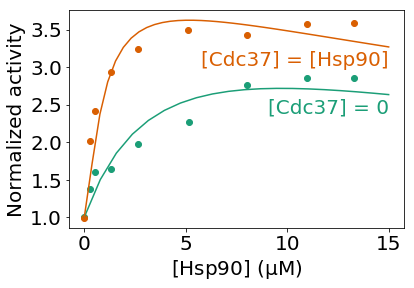

In [13]:
def plot_vSrc_activity( data, vsrc, fontsize=20):
    oldfont = matplotlib.rcParams['font.size']
    matplotlib.rcParams.update( {'font.size': fontsize})
    colors = ['#1b9e77','#d95f02','#7570b3']
    fig, ax = plt.subplots()
    ax.plot( vsrc['Hsp90'][:,0], vsrc['Hsp90'][:,1], 'o', color=colors[0])
    ax.plot( vsrc['Hsp90CDC37E'][:,0], vsrc['Hsp90CDC37E'][:,1], 'o', color=colors[1])
    ax.set_xlabel( '[Hsp90] ($\mathrm{\mu}$M)')
    ax.set_ylabel('Normalized activity')
    
    nact = dict([ (h, data[h]['active'][:]/data[h]['active'][0]) for h in ['H', 'QH']])
    ax.plot( data['H']['values'], nact['H'], color=colors[0])
    ax.plot( data['QH']['values'], nact['QH'], color=colors[1])
    
    xmax = data['H']['values'][-1]
    
    ax.text( xmax, nact['H'][-1]-0.05, '[Cdc37] = 0', horizontalalignment='right', verticalalignment='top',
           color=colors[0])
    ax.text( xmax, nact['QH'][-1]-0.05, '[Cdc37] = [Hsp90]', horizontalalignment='right', verticalalignment='top',
           color=colors[1])
    
    matplotlib.rcParams.update( {'font.size': oldfont})
    return fig

figvsrc = plot_vSrc_activity( data, vsrc)
figvsrc.savefig( 'figures/v-Src-activity.eps', bbox_inches='tight')

### Activation kinetics and ATP consumption

In [14]:
def activation_timeline(M=0.32, tmax=90):
    minute = 60
    concs = dict(ATP=20, ADP=1, Pi=1, M=M, Q=1.3, H=1.3)
    rxs, ks = hsp90.ATP_cochaperone_conformational_cycle( hsp90.BASE_RATES)
    nATPs = conformers.consumptive_reactions( rxs, 'ATP')
    Crx, ks, Nh, cc, mols, comps = hsp90.ATP_driven_conformer_rxs( rxs, ks, concs)
    mt0 = np.zeros( len(mols))
    molid = dict([(m, i) for i, m in enumerate(mols)])
    cmpid = dict([(c, i) for i, c in enumerate(comps)])
    Mi, Md, Mm, Ma = hsp90.conformational_equilibrium( hsp90.BASE_RATES, M=M)
    for m, c in [('M_i', Mi), ('M_d', Md), ('M_m', Mm), ('M_a', Ma), ('Q', cc[cmpid['Q']]), ('H_O', cc[cmpid['H']])]:
        mt0[molid[m]] = c
    moft = ness.kinetics( Crx, ks, mt0, tmax*minute)
    active = moft.y[molid['M_a'], :]
    
    DATPs = ness.cumulative_consumption( Crx, ks, nATPs, moft.t, moft.y)
    # Each hydrolysis cycle consumes two ATP.
    DATPs *= 2
    return moft, active, DATPs

moft, active, DATPs = activation_timeline()

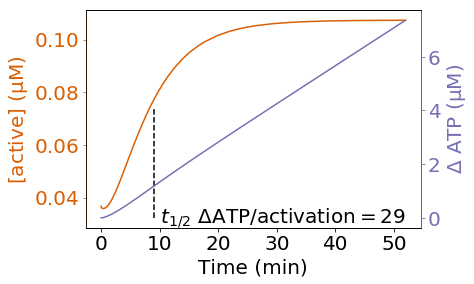

In [15]:
def plot_activation_timeline( t, active, DATPs, tmax=60, tATP=9, fontsize=20):
    oldfont = matplotlib.rcParams['font.size']
    matplotlib.rcParams.update( {'font.size': fontsize})
    colors = ['#d95f02','#7570b3']
    minute = 60
    fig, ax = plt.subplots()
    t = t/minute

    def ilim( tlim):
        return np.max(np.arange(len(t))[t <= tlim])

    imax = ilim( tmax)
    t = t[:imax]
    active = active[:imax]
    DATPs = DATPs[:imax]

    iATP = ilim( tATP)
    dATPperActive = DATPs[iATP]/(active[iATP]-active[0])
    
    ax.plot( t, active, color=colors[0])
    ax.set_xlabel( 'Time (min)')
    ax.set_ylabel( '[active] ($\mathrm{\mu}$M)')
    ax.spines['left'].set_color( colors[0])
    ax.yaxis.label.set_color( colors[0])
    ax.tick_params( axis='y', colors=colors[0])
    
    ax2 = ax.twinx()
    ax2.plot( t, DATPs, color=colors[1])
    ax2.set_ylabel( '$\Delta$ ATP ($\mathrm{\mu}$M)')
    ax2.spines['right'].set_color( colors[1])
    ax2.yaxis.label.set_color( colors[1])
    ax2.tick_params( axis='y', colors=colors[1])

    ymin, ymax = ax.get_ylim()
    ax.plot( [tATP, tATP], [ymin, active[iATP]], '--', color='k')
    ax2.text( tATP, 0.45, r' ${t_{1/2}}\ \Delta \mathrm{ATP}/\mathrm{activation} = %.2g$' % (dATPperActive),
            verticalalignment='top', horizontalalignment='left')
    
    matplotlib.rcParams.update( {'font.size': oldfont})
    return fig

figtimeline = plot_activation_timeline( moft.t, active, DATPs)
figtimeline.savefig( 'figures/v-Src-timeline.eps', bbox_inches='tight')

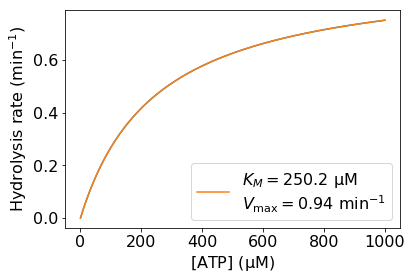

In [16]:
def hydrolysis_rate_vs_ATP( H=1.3, rates=None):
    if rates is not None:
        rates = dict( hsp90.BASE_RATES, **rates)
    else:
        rates = hsp90.BASE_RATES
    rxs, ks = hsp90.ATP_driven_cycle( rates)
    nATPs = conformers.consumptive_reactions( rxs, 'ATP')
    concs = dict(H=H, ATP=None, ADP=1., Pi=1.)
    atps = np.linspace( 0, 1000, 200)
    hrates = np.zeros( len(atps))
    for k, atp in enumerate( atps):
        concs['ATP'] = atp
        Crx, ksp, Nh, cc, mols, comps = conformers.driven_conformer_rxs( rxs, ks, concs, ['ATP', 'ADP', 'Pi'])
        if k==0:
            U, S, Vh = svd( Crx)
        mss = ness.ness( Crx, ksp, U=U, S=S, Vh=Vh, Nh=Nh, Nhmt0=cc)
        # print zip(mols, mss.x)
        hrates[k] = ness.consumption_rate( Crx, ksp, nATPs, mss.x)
    return atps, hrates/H

def plot_hydrolysis_rates_vs_ATP( rates=None):
    atps, hrates= hydrolysis_rate_vs_ATP( rates=rates)
    minute = 60.
    hrates *= minute
    KM, Vmax = ness.Michaelis_Menten( atps[1:], hrates[1:])
    fig, ax = plt.subplots()
    ax.plot( atps, hrates)
    MM = Vmax*atps/(KM + atps)
    ax.plot( atps, MM, label=(r'$K_M=%.1f\ \mathrm{\mu}$M' % KM) + '\n' + (r'$V_{\mathrm{max}}=%.2g$ min$^{-1}$' % Vmax) )
    ax.set_xlabel( '[ATP] ($\mathrm{\mu}$M)')
    ax.set_ylabel( 'Hydrolysis rate (min$^{-1}$)')
    ax.legend( loc='best')
    return fig

_ = plot_hydrolysis_rates_vs_ATP()

## Effect of loss-of-ATP-binding and loss-ATP-hydrolysis mutations 

In [17]:
def hsp90_activity( rates, concs):
    # First, compute the ATP hydrolysis rates and the corresponding Km and Vmax.
    atps, hrates = hydrolysis_rate_vs_ATP( rates=rates)
    minute = 60
    hrates *= minute
    KM, Vmax = ness.Michaelis_Menten( atps[1:], hrates[1:])
    
    # Compute the steady state client activity.
    rates = dict( hsp90.BASE_RATES, **rates)
    #for rx in rates:
    #    print rx, rates[rx]
    noneq, c, mol2id = hsp90.ATP_cochaperone_driven_conformational_noneq( rates, concs)
    a = c[mol2id['M_a']] # steady state active client concentration
    i0, d0, m0, a0 = hsp90.conformational_equilibrium( rates, concs['M'])
    
    for m in mol2id:
        if 'Q' in m: continue
        print m, c[mol2id[m]]
    
    return dict(activity = a/a0,
                KM = KM,
                Vmax = Vmax)

v-Src activity mediated by wild-type Hsp90

In [18]:
hsp90_activity( {'H_O+ATP=H_O.ATP': (6.66e-4, 0.145), 'H_C.ATP=H_C.ADP+Pi': (3.3e-1, None)}, dict(H=1.3, M=0.32, Q=0, ATP=20, ADP=1, Pi=1))

max(|J|) = 5.91149e-12
M_m.H_C.ATP 0.0002165175154557211
M_i 0.2165491729904313
M_m 0.0009832145466309977
M_a 0.06401608559016837
M_d 0.0004330983459812947
M_m.H_O 0.000931194816008967
H_O 0.5153056854631018
M_d.H_O 0.03234843699094379
H_O.ATP 0.04229878422154588
H_C.ADP 0.05223685123078535
M_d.H_C.ADP 0.0008404147206551063
H_C.ATP 0.002140250557778894
M_d.H_C.ATP 0.0007666337161054226
M_m.H_O.ATP 4.939935708383369e-05
M_m.H_C.ADP 0.0019282643952531046
M_d.H_O.ATP 0.000937567015282056


{'KM': 250.22854695575865,
 'Vmax': 0.9386789904985238,
 'activity': 1.7424680874951344}

v-Src activity mediated by an Hsp90 variant that loses ATP hydrolysis (e.g. E42A)

In [19]:
hsp90_activity( {'H_O+ATP=H_O.ATP': (6.66e-4, 0.145), 'H_C.ATP=H_C.ADP+Pi': (3.3e-5, None)}, dict(H=1.3, M=0.32, Q=0, ATP=20, ADP=1, Pi=1))

max(|J|) = 2.54109e-13
M_m.H_C.ATP 0.015315972774856457
M_i 0.2519767713536467
M_m 0.0005087589135304946
M_a 0.03312476840881438
M_d 0.000503953542707796
M_m.H_O 2.7792935876480754e-05
H_O 0.03266488385238727
M_d.H_O 0.0028549921394961067
H_O.ATP 0.002869188999391877
H_C.ADP 0.0032855391089706273
M_d.H_C.ADP 5.23502993923324e-05
H_C.ATP 0.5772946402579495
M_d.H_C.ATP 0.015320778145679151
M_m.H_O.ATP 2.374440506342514e-06
M_m.H_C.ADP 5.592487410403625e-05
M_d.H_O.ATP 0.00025556217138974113


{'KM': 1.238584922954784,
 'Vmax': 0.0019701432550805562,
 'activity': 0.9016304468777223}

v-Src activity mediated by an Hsp90 variant that loses ATP binding (e.g. D88A)

In [20]:
hsp90_activity( {'H_O+ATP=H_O.ATP': (6.66e-4, 14.5)}, dict(H=1.3, M=0.32, Q=0, ATP=20, ADP=1, Pi=1))

max(|J|) = 2.92429e-12
M_m.H_C.ATP 8.092056753991573e-06
M_i 0.2380886815788713
M_m 0.0005015397218999337
M_a 0.0326547342836101
M_d 0.00047617736315821784
M_m.H_O 0.00044969009033460973
H_O 0.5465326432179186
M_d.H_O 0.04600017587608111
H_O.ATP 0.0005014780110097236
H_C.ADP 0.05466163773636898
M_d.H_C.ADP 0.0008463718360950295
H_C.ATP 2.5373982242161897e-05
M_d.H_C.ATP 3.345441549570729e-05
M_m.H_O.ATP 4.040464161368361e-07
M_m.H_C.ADP 0.0008993578043647512
M_d.H_O.ATP 4.132092691909477e-05


{'KM': 22464.703079730745,
 'Vmax': 0.9386773400209749,
 'activity': 0.8888364833660275}

## Effects of Cdc37

In [21]:
condition['dATP-kdm'] = [ dict(Q=0), dict(Q=0.5), dict(Q=1.5) ]
data['dATP-kdm'] = [ analyze_ATP_hydrolysis_vs_rates( 'M_d=M_m', SCALEFORWARD, ATP=100, H=1.5, Q=cond['Q'], M=0.5) 
                    for cond in condition['dATP-kdm'] ]

In [22]:
condition['dATP-kATP'] = [ dict(ATP=20), dict(ATP=250), dict(ATP=1000)]
data['dATP-kATP'] = [ analyze_ATP_hydrolysis_vs_rates( 'H_C.ATP=H_C.ADP+Pi', SCALEFORWARD, ATP=cond['ATP'])
                     for cond in condition['dATP-kATP'] ]

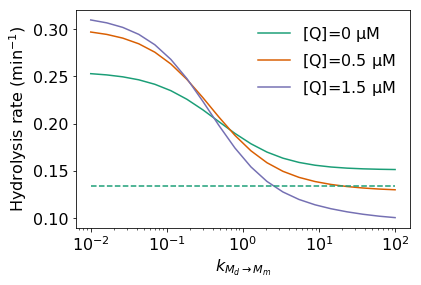

In [23]:
def plot_hydrolysis_rates_vs_rates( data, condition, xlabel):
    colors = ['#1b9e77','#d95f02','#7570b3']
    minute = 60.
    fig, ax = plt.subplots()
    for j, (c, d) in enumerate(zip( condition, data)):
        ax.plot( d['values'], d['dATPdt']*minute, color=colors[j], 
                label=','.join( [ r'[%s]=%g $\mathrm{\mu}$M' % (k, c[k]) for k in c]))
    ax.plot( d['values'], d['dATPdt0']*minute, '--', color=colors[0])
    ax.set_xscale( 'log')
    ax.set_xlabel( xlabel)
    ax.set_ylabel( 'Hydrolysis rate (min$^{-1}$)')
    ax.legend( loc='best', frameon=False)
    return fig
    
_ = plot_hydrolysis_rates_vs_rates( data['dATP-kdm'], condition['dATP-kdm'], r'$k_{M_d \rightarrow M_m}$')

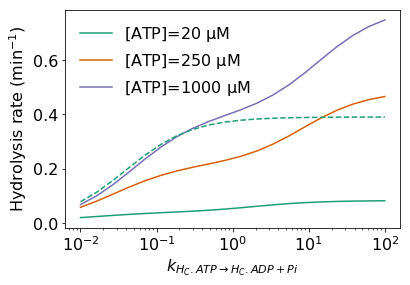

In [24]:
_ = plot_hydrolysis_rates_vs_rates( data['dATP-kATP'], condition['dATP-kATP'], r'$k_{H_C.ATP\rightarrow H_C.ADP+Pi}$')

In [25]:
def analyze_Q_effect( smin=0, smax=2, npts=20, ATP=250, H=1.3, M=0.32, rates=None):
    if rates is None:
        rates = hsp90.BASE_RATES
    condition = [ dict(Q=0.), dict(Q=2)]
    result = []
    kad, kdd = rates['M_d+H_O=M_d.H_O']
    kOCm, kCOm = rates['M_m.H_O.ATP=M_m.H_C.ATP']
    
    s = np.logspace( smin, smax, npts)
    krx = np.zeros( (npts, 2, 2))
    krx[:, 0, 0] = kad
    krx[:, 0, 1] = kdd*s
    krx[:, 1, 0] = kOCm
    krx[:, 1, 1] = kCOm*s
    
    for c in condition:
        concs = dict(ATP=ATP, ADP=1., Pi=1., M=M, H=H, Q=c['Q'])
        cmols, mols, noneq = hsp90.ness_vs_krx( rates, concs, [ 'M_m+H_O=M_m.H_O', 
                                                              'M_d.H_O.ATP=M_d.H_C.ATP'], krx)
        molid = dict([(m, i) for i, m in enumerate(mols)])
        result.append( dict(values=s, active=cmols[:,molid['M_a']], noneq=noneq))
    
    ceq = hsp90.conformational_equilibrium( rates, M=M)
    for r in result:
        r['active-eq'] = ceq[-1]
        
    return result, condition

data['Q-dep'], condition['Q-dep'] = analyze_Q_effect()

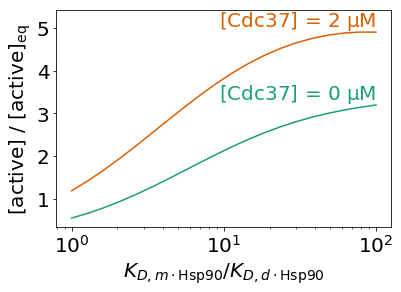

In [26]:
def plot_Q_effect( data, condition, fontsize=20):
    oldfont = matplotlib.rcParams['font.size']
    matplotlib.rcParams.update( {'font.size': fontsize})
    colors = ['#1b9e77','#d95f02','#7570b3']
    fig, ax = plt.subplots()
    
    smin, smax = min(data[0]['values']), max(data[0]['values'])
    for i, (d, c) in enumerate(zip( data, condition)):
        active = d['active']/d['active-eq']  # Normalized activity
        ax.plot( d['values'], active, color=colors[i])
        ax.text( d['values'][-1], max(active), r'[Cdc37] = %g $\mathrm{\mu}$M' % c['Q'],
               verticalalignment='bottom', horizontalalignment='right', color=colors[i])
    
    ax.set_xscale( 'log')
    xlabel = r'$K_{D,m\cdot \mathrm{Hsp90}}/K_{D,d\cdot \mathrm{Hsp90}}$'
    num = 'K_{d\cdot \mathrm{Hsp90}_{\mathrm{open}}^{\mathrm{ATP}}\, \leftrightharpoons\, d\cdot \mathrm{Hsp90}_{\mathrm{closed}}^{\mathrm{ATP}}}'
    den = 'K_{m\cdot \mathrm{Hsp90}_{\mathrm{open}}^{\mathrm{ATP}}\, \leftrightharpoons\, m\cdot \mathrm{Hsp90}_{\mathrm{closed}}^{\mathrm{ATP}}}'
    # xlabel += r'$(= \frac{%s}{%s})$' % (num, den)
    ax.set_xlabel( xlabel)
    
    ax.set_ylabel( r'[active] / [active]$_{\mathrm{eq}}$')
    ymin, ymax = ax.get_ylim()
    ax.set_ylim( ymin, ymax+0.3)
    matplotlib.rcParams.update( {'font.size': oldfont})
    return fig

figcdc37 = plot_Q_effect( data['Q-dep'], condition['Q-dep'])
figcdc37.savefig( 'figures/cdc37-role.eps', bbox_inches='tight')

## Miscellaneous analysis

In [27]:
data['vdm'] = analyze_hsp90_noneq_vs_rates( 'M_d=M_m', SCALEBOTH)

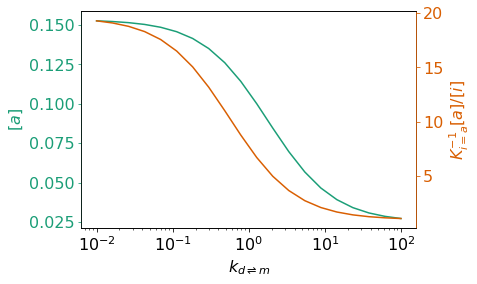

In [28]:
def plot_ATP_cochaperone_conformation_noneq( variable, data, label=None):
    colors = ['#1b9e77','#d95f02','#7570b3']
    # colors = ['#66c2a5','#fc8d62','#8da0cb']
    varlabel = dict( H=r'$[H]$', QH=r'$[Q]=[Hsp90]$', kdi=r'$k_{d\rightarrow i}$', vdm=r'$k_{d\rightleftharpoons m}$', kATP=r'$k_{H_C.ATP=H_C.ADP+Pi}$', kOC=r'$k_{O\rightarrow C}$',
                   kMH=r'$k_{M+Hsp90\rightarrow M\cdot Hsp90}$', kQMO=r'$k_{Q.M_i.H_O\rightarrow M_i.H_O+Q}$',
                   kQM=r'$k_{Q.M_d\rightarrow M_d+Q}$',
                   KmATP=r'$K_{m,ATP}$')
    xscale = dict( H='linear', QH='linear', Q='linear')
    xscale = dict( xscale, **dict( [(k, 'log') for k in ['kdi', 'kdm','kATP', 'kOC', 'kMH', 'kQMO', 'kQM','KmATP']]))
    fig, ax = plt.subplots()
    
    x = data['values']
    active = data['active']
    noneq = data['noneq']
        
    ax.plot( x, active, color=colors[0])
    ax.set_ylabel( r'$[a]$', color=colors[0])
    ax.set_xscale( xscale.get(variable, 'log'))
    if label is not None:
        ax.set_xlabel( label)
    else:
        ax.set_xlabel( varlabel.get(variable, 'k'))
    ax.spines['left'].set_color( colors[0])
    ax.yaxis.label.set_color( colors[0])
    ax.tick_params( axis='y', colors=colors[0])
    
    ax2 = ax.twinx()
    ax2.plot( x, noneq, color=colors[1])
    ax2.set_ylabel( r'$K_{i=a}^{-1} [a]/[i]$', color=colors[1])
    ax2.spines['right'].set_color( colors[1])
    ax2.yaxis.label.set_color( colors[1])
    ax2.tick_params( axis='y', colors=colors[1])
    
    return fig, data

_ = plot_ATP_cochaperone_conformation_noneq( 'vdm', data['vdm'])

In [29]:
data['ATP'] = analyze_hsp90_noneq_vs_concs( ['ATP'], cmin=2e-1, cmax=2000, Q=1.3, spacing='log')

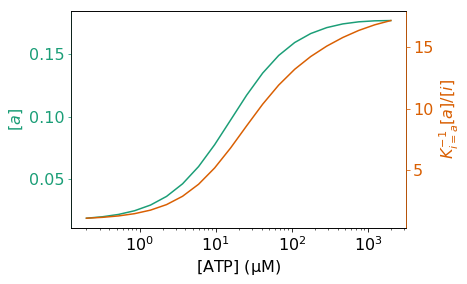

In [30]:
_ = plot_ATP_cochaperone_conformation_noneq( 'ATP', data['ATP'], '[ATP] ($\mathrm{\mu}$M)')

In [31]:
data['kCO'] = analyze_hsp90_noneq_vs_rates( ['M_d.H_O.ATP=M_d.H_C.ATP', 'M_m.H_O.ATP=M_m.H_C.ATP'], SCALEREVERSE)

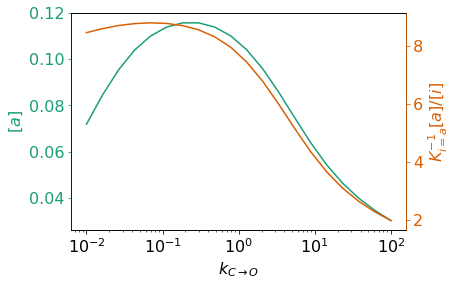

In [32]:
_ = plot_ATP_cochaperone_conformation_noneq( 'kCO', data['kCO'], r'$k_{C\rightarrow O}$')

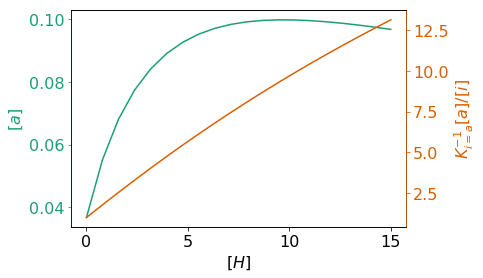

In [33]:
_ = plot_ATP_cochaperone_conformation_noneq( 'H', data['H'])

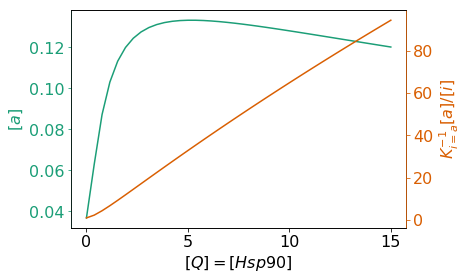

In [34]:
_ = plot_ATP_cochaperone_conformation_noneq( 'QH', data['QH'])

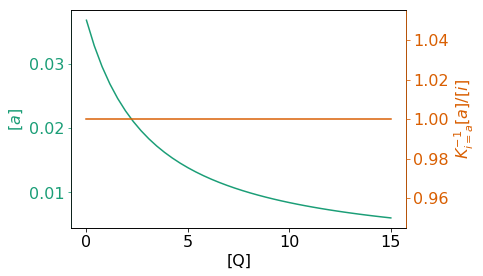

In [35]:
_ = plot_ATP_cochaperone_conformation_noneq( 'Q', data['Q'], '[Q]')

## Dependence on cycle timings

In [36]:
def analyze_rate_dependence( rx, scalewhich, rates=None, ATP=250, Q=0, M=0.32, npts=20, smin=0, smax=2):
    if rates is None:
        rates = hsp90.BASE_RATES
    
    result = analyze_hsp90_noneq_vs_rates( rx, scalewhich, smin=smin, smax=smax, Q=Q, M=M,
                                           ATP=ATP, npts=npts, rates=rates)
    dATP = analyze_ATP_hydrolysis_vs_rates( rx, scalewhich, smin=smin, smax=smax, M=M,
                                            Q=Q, ATP=ATP, npts=npts, rates=rates)
    kf, kr = rates[rx]
    if SCALEFORWARD==scalewhich: k = kf
    elif SCALEREVERSE==scalewhich: k = kr
    else: k = 1.
    result['values'] *= k
    result['dATPdt'] = dATP['dATPdt']
    
    eq = hsp90.conformational_equilibrium( rates, M)
    result['active-eq'] = eq[-1]
    return result

In [37]:
def analyze_kOC( rates=None, ATP=250, M=0.32, Q=0, npts=20, smin=0, smax=2):
    if rates is None:
        rates = hsp90.BASE_RATES
    
    kOC, kCO = rates['H_O.ATP=H_C.ATP']
    kOCd, kCOd = rates['M_d.H_O.ATP=M_d.H_C.ATP']
    kOCm, kCOm = rates['M_m.H_O.ATP=M_m.H_C.ATP']
    
    # We start with a client that does not accelerate the closure of the Hsp90.
    rates = dict( rates, **{'M_d.H_O.ATP=M_d.H_C.ATP': (kOC, kCOd),
                            'M_m.H_O.ATP=M_m.H_C.ATP': (kOC, kCOm)})
    
    
    rx = [ 'H_O.ATP=H_C.ATP', 'M_d.H_O.ATP=M_d.H_C.ATP', 'M_m.H_O.ATP=M_m.H_C.ATP']
    result = analyze_hsp90_noneq_vs_rates( rx, SCALEFORWARD, smin=smin, smax=smax, Q=Q, M=M,
                                           ATP=ATP, npts=npts, rates=rates)
    dATP = analyze_ATP_hydrolysis_vs_rates( rx, SCALEFORWARD, smin=smin, smax=smax, M=M,
                                            Q=Q, ATP=ATP, npts=npts, rates=rates)
    result['values'] *= kOC
    result['active'] /= M
    result['dATPdt'] = dATP['dATPdt']
    
    eq = hsp90.conformational_equilibrium( rates, M)
    result['active-eq'] = eq[-1]
    return result

data['kOC'] = analyze_kOC(ATP=250, Q=0)

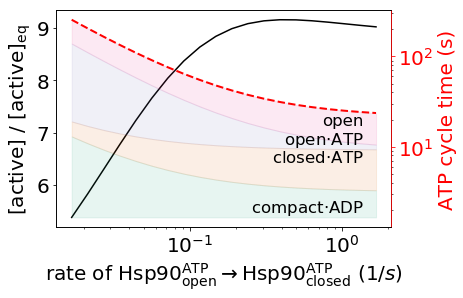

In [38]:
def plot_active_and_dATP_vs_rates( data, xlabel, fontsize=20):
    oldfont = matplotlib.rcParams['font.size']
    matplotlib.rcParams.update( {'font.size': fontsize})
    fig, ax = plt.subplots()
    rates = data['values']
    active = data['active']/data['active-eq']
    ax.plot( rates, active, color='k')
    ax.set_xscale( 'log')
    ax.set_ylabel( '[active] / [active]$_{\mathrm{eq}}$')
    ax.set_xlabel( xlabel)

    scolors = ['#1b9e77','#d95f02','#7570b3','#e7298a'] # ['#fef0d9','#fdcc8a','#fc8d59','#e34a33','#b30000']
    states = [ 'compact$\cdot$ADP', 'closed$\cdot$ATP', 'open$\cdot$ATP', 'open']
    pstates = data['pstates']
    dATPdt = data['dATPdt']
    t = 1/dATPdt
    tO = t*pstates['H_O']
    tOATP = t*pstates['H_O.ATP']
    tCATP = t*pstates['H_C.ATP']
    tCADP = t*pstates['H_C.ADP']
    ax2 = ax.twinx()
    rcolor = 'red'
    ax2.plot( rates, t, '--', lw=2, color=rcolor)
    bottom = np.zeros( len(rates))
    for i, (ti, state) in enumerate( zip([tCADP, tCATP, tOATP, tO], states)):
        top = bottom + ti
        if i>0: bot = bottom
        else: bot = bottom + np.min(top)/2
        ax2.fill_between( rates, bot, top, alpha=0.1, color=scolors[i])
        if i % 2 == 0:
            va = 'bottom'
            y = bot[-1]
        else:
            y = top[-1]
            va = 'top'
        ax2.text( rates[-1]/1.2, y, state, horizontalalignment='right', verticalalignment=va, fontsize='small')
        bottom = top
    ax2.set_ylabel( 'ATP cycle time (s)')
    ax2.set_yscale( 'log')
    ax2.spines['right'].set_color( rcolor)
    ax2.yaxis.label.set_color( rcolor)
    ax2.tick_params( axis='y', colors=rcolor)    

    matplotlib.rcParams.update( {'font.size': oldfont})
    return fig

_label = r'rate of ${\mathrm{Hsp90}_{\mathrm{open}}^{\mathrm{ATP}} \rightarrow \mathrm{Hsp90}_{\mathrm{closed}}^{\mathrm{ATP}}} \ (1/s)$'
figkOC = plot_active_and_dATP_vs_rates( data['kOC'], _label)
figkOC.savefig( 'figures/kOC.pdf', bbox_inches='tight')

In [39]:
data['kATP'] = analyze_rate_dependence( 'H_C.ATP=H_C.ADP+Pi', SCALEFORWARD, smin=-2, smax=0.5)

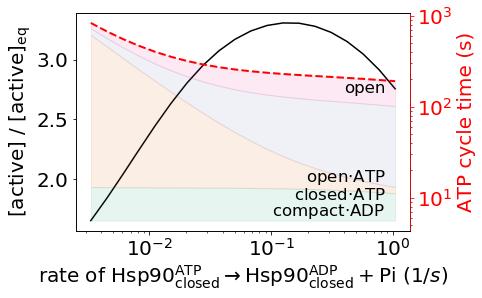

In [40]:
_label = r'rate of ${\mathrm{Hsp90}_{\mathrm{closed}}^{\mathrm{ATP}} \rightarrow \mathrm{Hsp90}_{\mathrm{closed}}^{\mathrm{ADP}} + \mathrm{Pi}} \ (1/s)$'
figkATP = plot_active_and_dATP_vs_rates( data['kATP'], _label)
figkATP.savefig( 'figures/kATP.pdf', bbox_inches='tight')

In [41]:
data['kdADP'] = analyze_rate_dependence( 'H_C.ADP=H_O+ADP', SCALEFORWARD, smin=-2, smax=1)

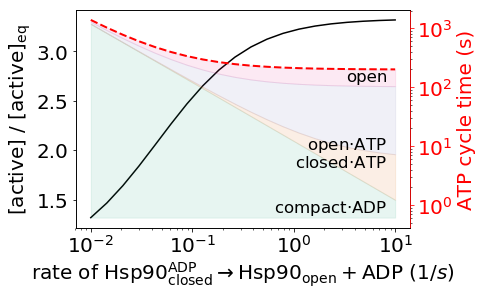

In [42]:
_label = r'rate of ${\mathrm{Hsp90}_{\mathrm{closed}}^{\mathrm{ADP}} \rightarrow \mathrm{Hsp90}_{\mathrm{open}} + \mathrm{ADP}}\  (1/s)$'
figkdADP = plot_active_and_dATP_vs_rates( data['kdADP'], _label)
figkdADP.savefig( 'figures/kdADP.pdf', bbox_inches='tight')

## The effects of Aha1 cochaperone 

In [43]:
def analyze_AHA1( ATP=1000, rates=None, npts=20, smin=-1, smax=2):
    if rates is None:
        rates = hsp90.BASE_RATES
    
    kOC, kCO = rates['H_O.ATP=H_C.ATP']
    kOCd, kCOd = rates['M_d.H_O.ATP=M_d.H_C.ATP']
    lOCm, kCOm = rates['M_m.H_O.ATP=M_m.H_C.ATP']
    
    rx = [ 'M_d.H_O.ATP=M_d.H_C.ATP', 'M_m.H_O.ATP=M_m.H_C.ATP' ]
    rates = dict( rates, **{ rx[0]: (kOC, kCOd),
                             rx[1]: (kOC, kCOm)})
    condition = [dict(AHA1=0), dict(AHA1=1)]
    result = [ analyze_hsp90_noneq_vs_rates( rx, SCALEFORWARD, smin=smin, smax=smax, AHA1=c['AHA1'], 
                                           Q=0, ATP=ATP, rates=rates)
             for c in condition]
    return result, condition

data['AHA1'], condition['AHA1'] = analyze_AHA1()

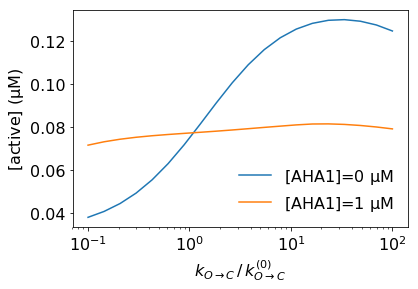

In [44]:
def plot_AHA1_effect( data, condition):
    fig, ax = plt.subplots()
    for i, (c, d) in enumerate( zip( condition, data)):
        ax.plot( d['values'], d['active'], label=','.join( [ r'[%s]=%g $\mathrm{\mu}$M' % (k, c[k]) for k in c]))
    ax.set_xscale('log')
    ax.set_xlabel( r'$k_{O\rightarrow C}\,/\,k_{O\rightarrow C}^{(0)}$')
    ax.set_ylabel( r'[active] ($\mathrm{\mu}$M)')
    ax.legend( loc='best', frameon=False)
    return fig

_ = plot_AHA1_effect( data['AHA1'], condition['AHA1'])

In [45]:
def analyze_AHA1_dATP( ATP=250, Amax=1.5, rates=None, npts=25):
    if rates is None:
        rates = hsp90.BASE_RATES
    
    concs = dict( ATP=ATP, ADP=1, Pi=1, H=1, A=0, M=0, Q=0)
    components = ['A']
    ccs = np.linspace( 0, Amax, npts)
    dATP = hsp90.dATP_vs_concs( rates, concs, components, ccs)
    return dict(values=ccs, dATPdt=dATP)

data['AHA1-dATP'] = analyze_AHA1_dATP()

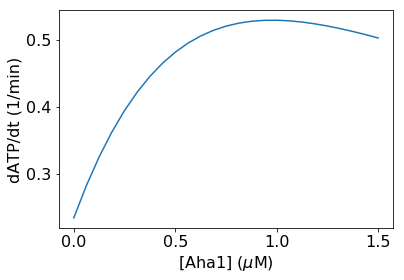

In [46]:
def plot_dATP_vs_AHA1( data):
    fig, ax = plt.subplots()
    aha1 = data['values']
    dATP = data['dATPdt']
    minute = 60
    ax.plot( aha1, minute*dATP)
    ax.set_xlabel( '[Aha1] ($\mu$M)')
    ax.set_ylabel( 'dATP/dt (1/min)')
    return fig

_ = plot_dATP_vs_AHA1( data['AHA1-dATP'])

In [47]:
def analyze_AHA1_concentration_dependence( ATP=250, M=0.32, rates=None, npts=20):
    if rates is None:
        rates = hsp90.BASE_RATES
    
    rxd = 'M_d.H_O.ATP=M_d.H_C.ATP'
    rxm = 'M_m.H_O.ATP=M_m.H_C.ATP'
    kOC, kCO = rates['H_O.ATP=H_C.ATP']
    kOCd, kCOd = rates[rxd]
    kOCm, kCOm = rates[rxm]
    
    condition = [dict(kOC=0.1*kOC), dict(kOC=20*kOC)]
    result = [ analyze_hsp90_noneq_vs_concs( ['A'], cmin=0, cmax=1.5, ATP=ATP, Q=0, M=M, npts=npts,
                                            rates=dict(rates, **{ rxd: (c['kOC'], kCOd),
                                                                  rxm: (c['kOC'], kCOm)}))
               for c in condition]
    eq = hsp90.conformational_equilibrium( rates, M)
    for r in result:
        r['active-eq'] = eq[-1]
    return result, condition

data['AHA1-conc'], condition['AHA1-conc'] = analyze_AHA1_concentration_dependence( ATP=250, npts=25)

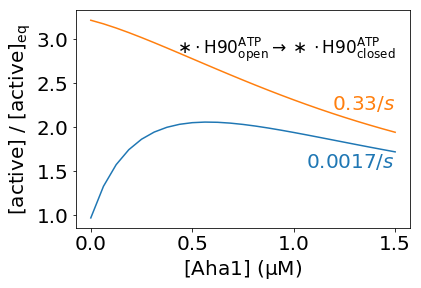

In [48]:
def plot_AHA1_concentration_dependence( data, condition, fontsize=20):
    oldfont = matplotlib.rcParams['font.size']
    matplotlib.rcParams.update( {'font.size': fontsize})
    from matplotlib.patches import Rectangle
    fig, ax = plt.subplots()
    lines = []
    for i, (c, d) in enumerate( zip( condition, data)):
        nact = d['active']/d['active-eq']
        line, = ax.plot( d['values'], nact, label=r'%.2g$/s$' % c['kOC'])
        lines.append( line)
        if i==0: 
            va='top'
            y = y0 = nact[-1]
        else: 
            va='bottom'
            y = y1 = nact[-6]
        ax.text( d['values'][-1], y, line.get_label(), color=line.get_color(), ha='right', va=va)
    ax.set_xlabel( '[Aha1] ($\mathrm{\mu}$M)')
    ax.set_ylabel( '[active] / [active]$_{\mathrm{eq}}$')
    ktext = r'${\ast\cdot\mathrm{H90}_{\mathrm{open}}^{\mathrm{ATP}}\rightarrow \ast\cdot\mathrm{H90}_{\mathrm{closed}}^{\mathrm{ATP}}}$'
    ymin, ymax = ax.get_ylim()
    ax.text( d['values'][-1], 3*y1 - 2*y0, ktext, ha='right', va='top', fontsize=17)
    #extra = Rectangle((0,0), 0.5, 0.5, fc='w', fill=False, edgecolor='none', linewidth=0)
    #leg = ax.legend( [ extra ] + lines, (ktext, lines[0].get_label(), lines[1].get_label()), 
    #                loc='lower center', frameon=False, fontsize=16)
    #plt.draw()
    #ax.set_ylim( ymin-0.2, ymax)
    matplotlib.rcParams.update( {'font.size': oldfont})
    return fig

figAha1 = plot_AHA1_concentration_dependence( data['AHA1-conc'], condition['AHA1-conc'])
figAha1.savefig( 'figures/Aha1.eps', bbox_inches='tight')

## Reaction network and reactive fluxes

In [49]:
BASELABELS = {
    'M_d': 'd',
    'M_m': 'm',
    'H_O': '\mathrm{H90}_{\mathrm{open}}',
    'H_O.ATP': '\mathrm{H90}_{\mathrm{open}}^{\mathrm{ATP}}',
    'H_C.ATP': '\mathrm{H90}_{\mathrm{closed}}^{\mathrm{ATP}}',
    'H_C.ADP': '\mathrm{H90}_{\mathrm{compact}}^{\mathrm{ADP}}',
    'Q': '\mathrm{C37}'
}
STATELABELS = {
    'M_d' : r'$%(M_d)s$' % BASELABELS,
    'M_m' : r'$%(M_m)s$' % BASELABELS,
    'M_d.H_O': r'$%(M_d)s\cdot %(H_O)s$' % BASELABELS,
    'M_m.H_O': r'$%(M_m)s\cdot %(H_O)s$' % BASELABELS,
    'M_d.H_O.ATP': r'$%(M_d)s\cdot %(H_O.ATP)s$' % BASELABELS,
    'M_m.H_O.ATP': r'$%(M_m)s\cdot %(H_O.ATP)s$' % BASELABELS,
    'M_d.H_C.ATP': r'$%(M_d)s\cdot %(H_C.ATP)s$' % BASELABELS,
    'M_m.H_C.ATP': r'$%(M_m)s\cdot %(H_C.ATP)s$' % BASELABELS,
    'M_d.H_C.ADP': r'$%(M_d)s\cdot %(H_C.ADP)s$' % BASELABELS,
    'M_m.H_C.ADP': r'$%(M_m)s\cdot %(H_C.ADP)s$' % BASELABELS,
    'Q.M_d': r'$%(M_d)s\cdot %(Q)s$' % BASELABELS,
    'Q.M_d.H_O': r'$%(M_d)s\cdot %(Q)s\cdot %(H_O)s$' % BASELABELS,
    'Q.M_d.H_O.ATP': r'$%(M_d)s\cdot %(Q)s\cdot %(H_O.ATP)s$' % BASELABELS,
    'Q.M_d.H_C.ATP': r'$%(M_d)s\cdot %(Q)s\cdot %(H_C.ATP)s$' % BASELABELS
}

In [50]:
reload(pltk)

<module 'plot_kinetics' from 'plot_kinetics.pyc'>

In [51]:
def plot_ATP_driven_reaction_network( rxs, ks, rmols, ax=None):
    mols = rxnet.allMolecules( rxs)
    mols = list(mols.intersection( rmols.keys()))
    molid = dict( [(m, i) for i, m in enumerate( mols)])
    
    kij = []
    for rx, (kf, kr) in zip(rxs, ks):
        rxtants, products = rxnet.reactants( rx)
        mr = set(rxtants).intersection( mols)
        mp = set(products).intersection( mols)
        if len(mr)==0 or len(mp)==0: continue
        assert( len(mr)==1 and len(mp)==1)
        mr = mr.pop()
        mp = mp.pop()
        kij.append( (molid[mr], molid[mp], kf, kr))
    
    # highlight the Hsp90 ATP cycles
    cycles = [ [ 'M_d.H_O', 'M_d.H_O.ATP', 'M_d.H_C.ATP', 'M_d.H_C.ADP' ],
              [ 'M_m.H_O', 'M_m.H_O.ATP', 'M_m.H_C.ATP', 'M_m.H_C.ADP'] ]
    nc = len(cycles[0])
    highlights = [ (molid[c[j % nc]], molid[c[(j+1) % nc]]) for j in xrange(nc) for c in cycles ]
    
    pos = np.array([ rmols[m] for m in mols])
    fig = pltk.plot_reaction_network(mols, pos, kij, node_symbol=None, highlights = highlights,
                                     label_nodes=False, kmin=1e-6, sepfactor=0.03, ax=ax)
    return fig

There are 30 reactions in total.
          H_C.ADP=H_O+ADP 1.000e+00 1.000e-01
       H_C.ATP=H_C.ADP+Pi 3.300e-01 9.289e-14
          H_O+ATP=H_O.ATP 6.660e-04 1.450e-01
              H_O+Q=Q.H_O 1.000e+00 1.400e+00
          H_O.ATP=H_C.ATP 1.670e-02 5.000e-05
  M_d+H_O.ATP=M_d.H_O.ATP 1.000e+00 5.603e-03
          M_d+H_O=M_d.H_O 1.000e+00 5.603e-03
      M_d+Q.H_O=Q.M_d.H_O 1.000e+00 4.834e-04
              M_d+Q=Q.M_d 1.000e+00 5.118e-03
  M_d.H_C.ADP=M_d.H_O+ADP 1.000e+00 1.816e-02
M_d.H_C.ATP+Q=Q.M_d.H_C.ATP 1.000e-01 1.000e-01
M_d.H_C.ATP=M_d.H_C.ADP+Pi 3.300e-01 9.289e-14
  M_d.H_C.ATP=M_m.H_C.ATP 1.000e-01 1.000e-01
  M_d.H_O+ATP=M_d.H_O.ATP 6.660e-04 1.450e-01
      M_d.H_O+Q=Q.M_d.H_O 2.000e-01 2.416e-02
M_d.H_O.ATP+Q=Q.M_d.H_O.ATP 1.000e+00 2.520e-02
  M_d.H_O.ATP=M_d.H_C.ATP 3.330e-01 5.490e-03
                  M_d=M_m 1.000e-01 1.000e-01
                  M_i=M_d 1.000e+00 5.000e+02
  M_m+H_O.ATP=M_m.H_O.ATP 1.000e+00 6.152e-01
          M_m+H_O=M_m.H_O 1.000e+00 6.152e

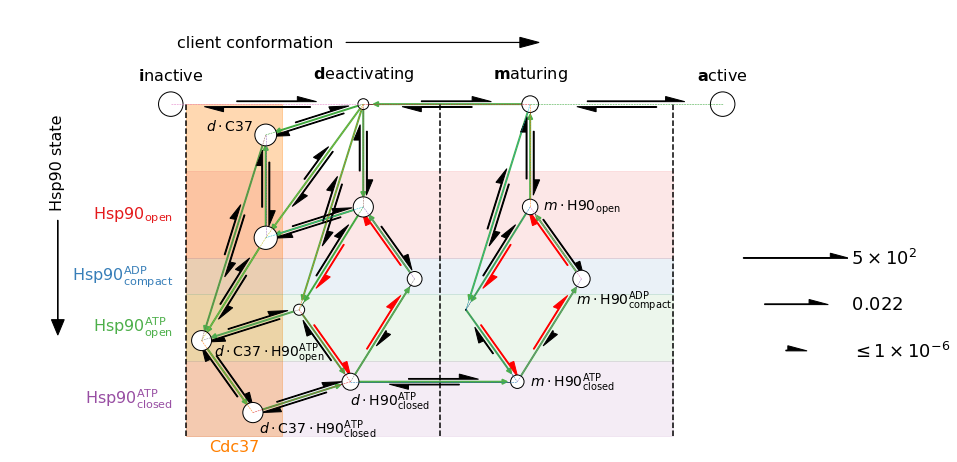

In [52]:
def plot_ATP_cochaperone_conformational_flux():
    rates = hsp90.BASE_RATES
    concs = { 'ATP': 20, 'ADP': 1., 'Pi': 1., 'M': 0.32, 'H': 1.3, 'Q': 1.3}
    rxs, ks = hsp90.ATP_cochaperone_conformational_cycle( rates)

    ksrx = dict( zip(rxs, ks))
    rxs_sorted = ksrx.keys()
    rxs_sorted.sort()
    print "There are %d reactions in total." % len(rxs_sorted)
    for rx in rxs_sorted:
        kf, kr = ksrx[rx]
        print '%25s' % rx, '%.3e' % kf, '%.3e' % kr
        
    rmols = hsp90.ATP_cochaperone_conformational_cycle_layout()
    Crx, ks, Nh, Nhmt0, mols, comps = hsp90.ATP_driven_conformer_rxs( rxs, ks, concs)
    molid = dict( [ (m, i) for i, m in enumerate( mols) ])
    mss = ness.ness( Crx, ks, Nh=Nh, Nhmt0=Nhmt0, tinit=100.)
    c = mss.x
    cmols = dict( zip(mols, c))
    Js = np.array([ ness.flux_in_reaction( Crx[r], ks[r], c) for r in xrange(Crx.shape[0])])
    J = rxnet.fluxNet( Js, rxs, rmols.keys())
    fig, ax = plt.subplots( figsize=(15, 8))
    nss = np.array( [ cmols[m] for m in rmols ])
    pltk.plot_reaction_flux( rmols.keys(), rmols, nss, J, ax, edge_width_min=0.1, edge_width_max=1, 
                            epsilon=1e-6, arrow_width=2)
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible( False)
    ax.set_xticks([])
    ax.set_yticks([])

    fig = plot_ATP_driven_reaction_network( rxs, ks, rmols, fig.gca())

    xys = np.array( rmols.values())
    xleft, ybottom = xys.min(axis=0)
    xright, ytop = xys.max(axis=0)
    xleft -= 0.05*(xright - xleft)
    # ytop += 0.1*(ytop - ybottom)
    ybottom -= 0.075*(ytop - ybottom)
    
    def state_bounds( rmols, is_state):
        rstate = np.array([ rmols[m] for m in rmols if is_state(m) ])
        return np.min( rstate, axis=0), np.max( rstate, axis=0)
    
    def label_client_states():
        qcolor = '#ff7f00'
        bi = state_bounds( rmols, lambda m: 'M_i' in m)
        bd = state_bounds( rmols, lambda m: 'M_d' in m)
        bm = state_bounds( rmols, lambda m: 'M_m' in m)
        ba = state_bounds( rmols, lambda m: 'M_a' in m)
        xi = bi[0][0], bi[1][0]
        xd = bd[0][0], bd[1][0]
        xm = bm[0][0], bm[1][0]
        xa = ba[0][0], ba[1][0]
        
        xid = 0.5*(xi[1] + xd[0])
        xdm = 0.5*(xd[1] + xm[0])
        xma = 0.35*xm[1] + 0.65*xa[0]
        
        ax.plot( [xid, xid], [ybottom, ytop], 'k--')
        ax.plot( [xdm, xdm], [ybottom, ytop], 'k--')
        ax.plot( [xma, xma], [ybottom, ytop], 'k--')
        
        labels = [ (r'$\mathbf{d}\mathrm{eactivating}$', rmols['M_d']),
                 (r'$\mathbf{i}\mathrm{nactive}$', rmols['M_i']),
                 (r'$\mathbf{a}\mathrm{ctive}$', rmols['M_a']),
                 (r'$\mathbf{m}\mathrm{aturing}$', rmols['M_m'])]
        for label, xy in labels:
            fig.gca().text( xy[0], xy[1] + 0.1, label, {'ha': 'center', 'va': 'bottom'})
        
        bq = state_bounds( rmols, lambda m: 'Q' in m)
        bdnoq = state_bounds( rmols, lambda m: 'M_d' in m and 'Q' not in m)
        xq = bq[0][0], bq[1][0]
        xdnoq = bdnoq[0][0], bdnoq[1][1]
        xq = (xid, 0.5*(xq[1] + xdnoq[0]))
        ax.fill_between( xq, ybottom, ytop, color=qcolor, alpha=0.3)
        fig.gca().text( 0.5*(xq[0] + xq[1]), ybottom-0.02, r'Cdc37', {'ha': 'center', 'va': 'top'}, color=qcolor)

        # Add an arrow on top to indicate this direction as client conformation
        xy = 0.5*(xleft + xright), ytop
        arlen = 0.3*(xright - xleft)
        dy = 0.3
        fig.gca().arrow( xy[0]-0.5*arlen, xy[1] + dy, arlen, 0, head_length=0.075, head_width=0.05, color='black')
        fig.gca().text( xy[0]-0.5*arlen - 0.05, xy[1] + dy, 'client conformation', 
                       verticalalignment='center', horizontalalignment='right')
        ymin, ymax = fig.gca().get_ylim()
        fig.gca().set_ylim( ymin, ymax+dy)
        
        return xid, xdm, xma
    
    xid, xdm, xma = label_client_states()
    xleft, xright = xid, xma
    def label_Hsp90_states():
        colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3']
        bapo = state_bounds( rmols, lambda m: 'H' not in m)
        bopen = state_bounds( rmols, lambda m: 'H_O' in m and 'H_O.ATP' not in m)
        bclosedADP = state_bounds( rmols, lambda m: 'H_C.ADP' in m)
        bopenATP = state_bounds( rmols, lambda m: 'H_O.ATP' in m)
        bclosedATP = state_bounds( rmols, lambda m: 'H_C.ATP' in m)
        
        yapo = bapo[0][1], bapo[1][1]
        yopen = bopen[0][1], bopen[1][1]
        yclosedADP = bclosedADP[0][1], bclosedADP[1][1]
        yopenATP = bopenATP[0][1], bopenATP[1][1]
        yclosedATP = bclosedATP[0][1], bclosedATP[1][1]
        
        yopen = (0.5*(yapo[0] + yopen[1]), 
                 0.5*(yopen[0] + yclosedADP[1]))
        yclosedADP = (yopen[1], 0.5*(yclosedADP[0] + yopenATP[1]))
        yopenATP = (yclosedADP[1], 0.5*(yopenATP[0] + yclosedATP[1]))
        yclosedATP = (yopenATP[1], ybottom)
        ax.fill_between( [xleft, xright], yopen[0], yopen[1], alpha=0.1, color=colors[0])
        ax.fill_between( [xleft, xright], yclosedADP[0], yclosedADP[1], alpha=0.1, color=colors[1])
        ax.fill_between( [xleft, xright], yopenATP[0], yopenATP[1], alpha=0.1, color=colors[2])
        ax.fill_between( [xleft, xright], yclosedATP[0], yclosedATP[1], alpha=0.1, color=colors[3])
        labels = [ (r'Hsp90$_{\mathrm{open}}$', yopen),
                (r'Hsp90$_{\mathrm{compact}}^{\mathrm{ADP}}$', yclosedADP),
                (r'Hsp90$_{\mathrm{open}}^{\mathrm{ATP}}$', yopenATP),
                (r'Hsp90$_{\mathrm{closed}}^{\mathrm{ATP}}$', yclosedATP) ]
        for i, (label, y) in enumerate(labels):
            fig.gca().text( xleft-0.05, 0.5*(y[0]+y[1]), label, {'ha': 'right', 'va': 'center'}, color=colors[i])
        
        # Add a vertical arrow to indicate Hsp90 states
        xy = xleft, 0.5*(ytop + ybottom)
        arlen = 0.3*(ytop - ybottom)
        dx = .5
        fig.gca().arrow( xy[0] - dx, xy[1] + 0.5*arlen, 0, -arlen, head_width=0.05, head_length=0.075, color='black')
        fig.gca().text( xy[0] - dx, xy[1] + 0.5*arlen + 0.05, 'Hsp90 state', rotation=90, 
                       horizontalalignment='center', verticalalignment='bottom')
        xmin, xmax = fig.gca().get_xlim()
        fig.gca().set_xlim( xmin - dx, xmax)
        
    label_Hsp90_states()
    
    def label_select_complexes():
        ax = fig.gca()
        mols = [ 'Q.M_d', # 'Q.M_d.H_O', 
                'Q.M_d.H_O.ATP', 'Q.M_d.H_C.ATP', 'M_d.H_C.ATP', 'M_m.H_C.ATP', 'M_m.H_C.ADP', 'M_m.H_O' ]
        labels = map( lambda m: STATELABELS[m], mols) 
        position = {'Q.M_d': ('right', 'bottom', -0.05, 0.01),
                    'Q.M_d.H_O': ('left', 'top', -0.01, -0.05),
                   'Q.M_d.H_O.ATP': ('left', 'top', 0.05, 0.0),
                   'Q.M_d.H_C.ATP': ('left', 'top', 0.025, -0.025),
                   'M_d.H_C.ATP': ('left', 'top', 0.0, -0.04),
                   'M_m.H_C.ATP': ('left', 'center', 0.05, 0.0),
                   'M_m.H_C.ADP': ('left', 'top', -0.02, -0.05),
                   'M_m.H_O': ('left', 'center', 0.05, 0.0)}
        for m, label in zip( mols, labels):
            ha, va, dx, dy = position[m] 
            ax.text( rmols[m][0]+dx, rmols[m][1]+dy, label, fontsize=14, va=va, ha=ha)
            
    label_select_complexes()
    
    print '[active]=%g' % cmols['M_a']
    return fig, cmols, molid

figflux, cmols1, molid1 = plot_ATP_cochaperone_conformational_flux()

In [53]:
# Saving as PDF to avoid the loss of transparency.  
# Use pdftops -eps hsp90-flux.pdf hsp90-flux.eps
figflux.savefig( 'figures/hsp90-flux.pdf', bbox_inches='tight')

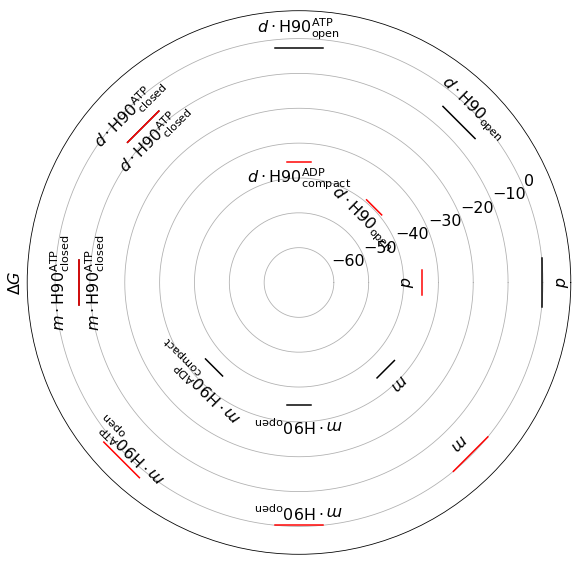

In [54]:
def plot_pathway_free_energy_landscape():
    rates = hsp90.BASE_RATES
    concs = { 'ATP': 20, 'ADP': 1., 'Pi': 1., 'M': 0.32, 'H': 1.3, 'Q': 1.3}
    rxs, ks = hsp90.ATP_cochaperone_conformational_cycle( rates)
    Crx, ksp, Nh, Nhmt0, mols, comps = hsp90.ATP_driven_conformer_rxs( rxs, ks, concs)
    molid = dict( [ (m, i) for i, m in enumerate( mols) ])
    mss = ness.ness( Crx, ksp, Nh=Nh, Nhmt0=Nhmt0, tinit=100.)
    c = mss.x
    c = np.random.rand( len(c))
    cmols = dict( zip(mols, c))
    cmols.update( **concs)

    pathdtom = [ 'M_d', 'M_d.H_O', 'M_d.H_O.ATP', 'M_d.H_C.ATP', 'M_m.H_C.ATP', 'M_m.H_C.ADP', 'M_m.H_O', 'M_m' ]
    pathmtod = [ m.replace( 'M_d', 'M_m') if 'M_d' in m else m.replace( 'M_m', 'M_d') for m in pathdtom ]
    
    shared = set(pathdtom).intersection( set(pathmtod))
    
    dGdtom = rxnet.pathway_free_energy_landscape( pathdtom, rxs, ks, cmols)
    dGmtod = rxnet.pathway_free_energy_landscape( pathmtod, rxs, ks, cmols)
    
    fig = plt.figure( figsize=(10, 10))
    ax = fig.add_subplot(111, polar=True)
    
    def draw_state( x, y, width=0.2, color='k'):
        ax.plot( x + 0.5*width*np.array([-1, 1]), [y, y], color)
    
    ntotal = float(len(dGdtom))
    for x, y in enumerate( dGdtom):
        angle = 2*np.pi*x/ntotal
        rotation = angle/np.pi*180 - 90
        draw_state( angle, y)
        ax.text( angle, y+5, STATELABELS[pathdtom[x]], rotation=rotation, ha='center', va='center')
        
    for x, y in enumerate( dGmtod):
        angle = 2*np.pi*(ntotal - x - 1)/ntotal
        rotation = angle/np.pi*180-90
        draw_state( angle, y, color='r')
        ax.text( angle, y-5, STATELABELS[pathmtod[x]], rotation=rotation, ha='center', va='center')
        
    ax.set_ylim( -70, 8)
    ax.set_xticks( [])
    # ax.set_xticks( np.arange(len(dGdtom)))
    # ax.set_xticklabels( [ STATELABELS[s] for s in pathdtom ], rotation=90)
    ax.set_ylabel( r'$\Delta G$')
    
    # print dGdtom[1:] - dGdtom[:-1]
    # print dGmtod[1:] - dGmtod[:-1]
    return fig
    
_ = plot_pathway_free_energy_landscape()

## Analyze the steady state of unhydrolyzable ATP analogs

In [55]:
def unhydrolyzable_ATP( H=15, M=0.32):
    rates = dict( hsp90.BASE_RATES, **{'H_C.ATP=H_C.ADP+Pi': (0, 0)})
    condition = [ dict(Q=0), dict(Q=2), dict(Q=15)]
    data = []
    for c in condition:
        concs = dict(ATP=250, ADP=1, Pi=1, H=15, Q=c['Q'], M=M)
        rxs, ks = hsp90.ATP_cochaperone_conformational_cycle( rates)
        Crx, ks, Nh, Nhmt0, mols, comps = hsp90.ATP_driven_conformer_rxs( rxs, ks, concs)
        molid = dict( [ (m, i) for i, m in enumerate( mols) ])
        mss = ness.ness( Crx, ks, Nh=Nh, Nhmt0=Nhmt0, tinit=100.)
        data.append( dict(molid=molid, cmols=mss.x, M=M))
    return data, condition

data['AMPPNP'], condition['AMPPNP'] = unhydrolyzable_ATP()

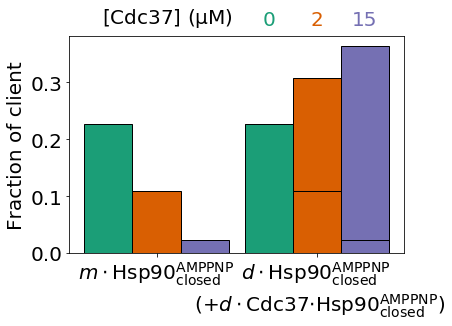

In [56]:
def plot_unhydrolyzable_ATP( data, condition, fontsize=20):
    oldfont = matplotlib.rcParams['font.size']
    matplotlib.rcParams.update( {'font.size': fontsize})
    colors = ['#1b9e77','#d95f02','#7570b3'] # ['#7fc97f','#beaed4','#fdc086']
    molid = data[0]['molid']
    # mols = filter( lambda m: 'M' in m and 'H_C' in m and 'ADP' not in m, molid.keys())
    mols = ['M_m.H_C.ATP', 'M_d.H_C.ATP', 'Q.M_d.H_C.ATP']
    fig, ax = plt.subplots()
    n = np.arange( len(mols))
    width=0.3
    rects = []
    for i, (c, d) in enumerate( zip(condition, data)):
        cmols = d['cmols']/d['M']
        k = i-1
        ax.bar( n[:2]+k*width, [ cmols[molid[m]] for m in mols[:2]], width, color=colors[i], edgecolor=['k']*2)
        rect = ax.bar( n[1]+k*width, cmols[molid[mols[-1]]], width, bottom=cmols[molid[mols[1]]], color=colors[i], 
                       edgecolor='k', linewidth=1, zorder=-9)
        rects.append( rect[0])
    
    ymax = max( [ rect.get_height() for rect in rects ])
    dx = rects[0].get_x() - rects[1].get_x()
    for i, (c, rect) in enumerate( zip( condition, rects)):
        ax.annotate( '%g' % c['Q'],
                   xy = (rect.get_x() + rect.get_width()/2, ymax), 
                   xytext = (0, 30),
                   textcoords = 'offset points',
                   ha='center', va='bottom', color=colors[i])
    ax.annotate( '[Cdc37] ($\mathrm{\mu}$M)', xy=(rects[0].get_x() + 0.25*dx, ymax), xytext=(0, 30),
                textcoords = 'offset points', ha='right', va='bottom')
    
    ax.set_ylabel( 'Fraction of client')
    ax.set_xticks( n[:2])
    ax.set_xticklabels( [r'$m\cdot$Hsp90$_{\mathrm{closed}}^\mathrm{AMPPNP}$',
                         '$d\cdot$Hsp90$_{\mathrm{closed}}^\mathrm{AMPPNP}$ \n (+$d\cdot$Cdc37$\cdot$Hsp90$_{\mathrm{closed}}^\mathrm{AMPPNP}$)'], 
                       rotation=0)
    # ax.legend( loc='best', frameon=False, fontsize='small')
    # ax.set_yscale('log')
    matplotlib.rcParams.update( {'font.size': oldfont})
    return fig

figAMPPNP = plot_unhydrolyzable_ATP( data['AMPPNP'], condition['AMPPNP'])
figAMPPNP.savefig( 'figures/AMPPNP.eps', bbox_inches='tight')

## CDC37 binding and kinase bilobial conformational equilibrium

CDC37 binds to the bilobial conformations of kinases, where the N- and C-lobes are separated. The binding to the kinase can thus be decomposed into two steps:

KIN $\overset{K_C}\leftrightharpoons$ KIN$^\ast$ + CDC37 $\overset{K_D^\ast}\leftrightharpoons$ KIN$^\ast\cdot$CDC37

The apparent/experimental binding affinity for CDC37 and kinase is then

$K_D = \frac{([\mathrm{KIN}]+[\mathrm{KIN}^\ast])[\mathrm{CDC37}]}{[\mathrm{KIN}^\ast\cdot \mathrm{CDC37}]}
= (1+K_C^{-1})K_D^\ast$

This constrains the parameters $K_C$ and $K_D^\ast$ by
$ K_C = (K_D/K_D^\ast - 1)^{-1}$ or $K_D^\ast = K_D(1+K_C^{-1})^{-1}$

The apparent $K_D$ for CDC37 binding to bRaf$^\mathrm{V600E}$ is $K_D = 0.2\mu M$ (Polier et al. 2013 Nature Chem. Biol.)

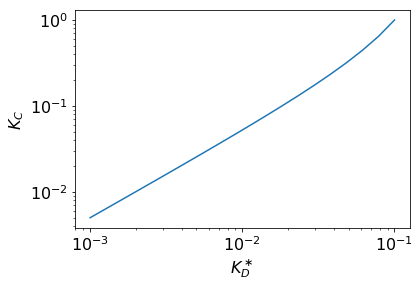

In [57]:
def plot_KC_vs_KDs( KD=0.2):
    KDs = np.logspace(-3, -1, 20)
    KC = 1/(KD/KDs - 1.)
    fig, ax = plt.subplots()
    ax.plot( KDs, KC)
    ax.set_xscale( 'log')
    ax.set_yscale( 'log')
    ax.set_xlabel( r'$K_D^\ast$')
    ax.set_ylabel( r'$K_C$')
    return fig

_ = plot_KC_vs_KDs()

For my calculations, I will assume that the bilobial conformation is rare and $K_C = 10^{-2}$, thus $K_D^\ast$ is

In [58]:
0.2/(1 + 1/1e-2)

0.0019801980198019802

The apparent $K_D$ of CDC37 for client, according to the model parameters.

In [59]:
def KDQd( rates):
    kid, kdi = rates['M_i=M_d']
    kma, kam = rates['M_m=M_a']
    kdm, kmd = rates['M_d=M_m']
    Kdi = kdi/kid
    Kdm = kdm/kmd
    Kma = kma/kam
    kaQd, kdQd = rates['M_d+Q=Q.M_d']
    KD = kdQd/kaQd*(1 + Kma*Kdm + Kdm + Kdi)
    return KD

KDQd( hsp90.BASE_RATES)

2.9022254097811073

In [60]:
def analyze_client_activation( rates=None, M=0.32):
    if rates is None:
        rates = hsp90.BASE_RATES
    result = analyze_hsp90_noneq_vs_rates( 'M_m=M_a', SCALEFORWARD, M=M, rates=rates, smin=-1.5, smax=2.5)
    result['active-eq'] = np.zeros( len(result['values']))
    result['Keq'] = np.zeros( len(result['values']))
    kma, kam = rates['M_m=M_a']
    for i, s in enumerate( result['values']):
        rates = dict( rates, **{'M_m=M_a': (s*kma, kam)})
        Keq = rxnet.KeqFromRXCycle( rates, [('M_i=M_d', 1),
                                           ('M_d=M_m', 1),
                                           ('M_m=M_a', 1)])
        result['active-eq'][i] = hsp90.conformational_equilibrium( rates, M)[-1]
        result['Keq'][i] = Keq
    return result

data['kma'] = analyze_client_activation()

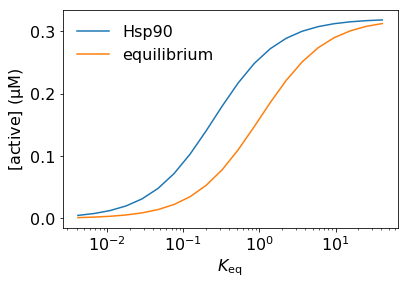

In [61]:
def plot_client_activation( data):
    fig, ax = plt.subplots()
    ax.plot( data['Keq'], data['active'], label='Hsp90')
    ax.plot( data['Keq'], data['active-eq'], label='equilibrium')
    ax.set_xscale( 'log')
    ax.set_xlabel( '$K_{\mathrm{eq}}$')
    ax.set_ylabel( '[active] ($\mathrm{\mu}$M)')
    ax.legend( loc='best', frameon=False)
    return fig

_ = plot_client_activation( data['kma'])